In [3]:
!git clone https://github.com/openai/gym.git
%cd gym
!pip install -e .
%cd ..

# Instalar a lib ptan
!pip install ptan

# libs de visualização
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

fatal: destination path 'gym' already exists and is not an empty directory.
/content/gym
Obtaining file:///content/gym
  Attempting uninstall: gym
    Found existing installation: gym 0.18.0
    Can't uninstall 'gym'. No files were found to uninstall.
  Running setup.py develop for gym
/content


# **Agente** (Rede neural)

*   Output da rede -> 



In [6]:
from torch import nn

class PGN(nn.Module):
  def __init__(self, input_size, n_actions):
    super(PGN, self).__init__()
    self.dense1 = nn.Linear(in_features =  input_size, out_features = 128)
    self.relu1 = nn.ReLU()
    self.dense2 = nn.Linear(in_features =  128, out_features = n_actions)

  def forward(self, x):
    #print("forward1")
    #print(x)
    out = self.relu1(self.dense1(x))
    #print("forward2")
    out =self.dense2(out)
    return out


# **Parâmetros de treinamento**

In [3]:
import time
import numpy as np
import collections
import torch
import torch.nn as nn
import torch.optim as optim

DEFAULT_ENV_NAME = "CartPole-v0"
GAMMA = 0.99
LEARNING_RATE = 0.01
EPISODES_TO_TRAIN = 4

# Definição da função $Q(s,a)$

In [7]:
def calc_qvals(rewards):
  res = []
  sum_r = 0.0
  for r in reversed(rewards):
    sum_r *= GAMMA
    sum_r += r
    res.append(sum_r)
  return list(reversed(res))

# Definição do **replay buffer**

Métodos policy gradient fazem parte da classe on-policy e não usam replay buffers (dados das políticas anteriores)

# Loop principal


Algumas considerações sobre objetos da lib ptan.

**ExperienceSource:** retorna pedaços da trajetória em cada iteração. O tamanho destes pedaços é definido pelo parâmetro steps_count. 
* Os pedaços da trajetória são formados por subtrajetóras (que são tuplas $(s,a,r)$). Ou seja, se steps_count = 3, então a cada iteração 3 subtrajetórias serão retornadas.
*  Se steps_count = 1, a cada iteração será retornada uma tupla $(s,a,r)$. Na primeira iteração temos o estado inicial, e na segunda iteração temos o estado resultante da ação tomada na primeira iteração.
*  Se steps_count = 2, a cada iteração será retornado um array contendo duas tuplas $(s,a,r)$. Dependendo do término do episódio, podem ser retornados duas ou uma tupla  $(s,a,r)$


**ExperienceSourceFirstLast:** retorna pedaços da trajetória, porém agora são tuplas $(s,a,r,s')$.

* Os pedaços da trajetória não contêm subtrajetórias, apenas o primeiro estado $s = s_1$ e o último $s' = s_{n+1}$, onde $n = $ *steps_count*, junto com a ação tomada em $s$ e o retorno acumulado $r$ obtido pelo agente do estado inicial $s_1$ até o final $s_{n+1}$





In [21]:
import gym 
import ptan

env = gym.make(DEFAULT_ENV_NAME)

net = PGN(env.observation_space.shape[0], env.action_space.n)
print(net)
agent = ptan.agent.PolicyAgent(net, preprocessor=ptan.agent.float32_preprocessor,apply_softmax=True)

exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=GAMMA)

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

total_rewards = []
done_episodes = 0
batch_episodes = 0
cur_rewards = []
batch_states, batch_actions, batch_qvals = [], [], []

for step_idx, exp in enumerate(exp_source):
  batch_states.append(exp.state)
  batch_actions.append(int(exp.action))
  cur_rewards.append(exp.reward)

  if exp.last_state is None:
    batch_qvals.extend(calc_qvals(cur_rewards))
    cur_rewards.clear() # remove all items from the reward list
    batch_episodes += 1

  new_rewards = exp_source.pop_total_rewards()
  if new_rewards: # if new_rewards is not empty
    done_episodes += 1
    reward = new_rewards[0]
    total_rewards.append(reward)
    mean_rewards = float(np.mean(total_rewards[-100:]))

    print("%d: reward: %6.2f, mean_100: %6.2f,"\
    "episodes: %d" % (step_idx, reward,mean_rewards,done_episodes))
    if mean_rewards > 195:
      torch.save(net.state_dict(), DEFAULT_ENV_NAME + "-PGN.dat")
      print("Solved in %d steps and %d episodes!" %
      (step_idx, done_episodes))
      break

  if batch_episodes < EPISODES_TO_TRAIN:
    continue

  # we convert states, actions, and Q-values into the appropriate PyTorch form.
  optimizer.zero_grad()
  states_v = torch.FloatTensor(batch_states)
  batch_actions_t = torch.LongTensor(batch_actions)
  batch_qvals_v = torch.FloatTensor(batch_qvals)

  # compute loss
  logits_v = net(states_v)
  log_prob_v = torch.nn.functional.log_softmax(logits_v, dim=1)
  log_prob_actions_v = batch_qvals_v * log_prob_v[
  range(len(batch_states)),
  batch_actions_t]
  loss_v = -log_prob_actions_v.mean()

  # backpropagation and perform an SGD update
  loss_v.backward()
  optimizer.step()
  batch_episodes = 0
  batch_states.clear()
  batch_actions.clear()
  batch_qvals.clear()

PGN(
  (dense1): Linear(in_features=4, out_features=128, bias=True)
  (relu1): ReLU()
  (dense2): Linear(in_features=128, out_features=2, bias=True)
)
20: reward:  20.00, mean_100:  20.00,episodes: 1
41: reward:  21.00, mean_100:  20.50,episodes: 2
97: reward:  56.00, mean_100:  32.33,episodes: 3
119: reward:  22.00, mean_100:  29.75,episodes: 4
138: reward:  19.00, mean_100:  27.60,episodes: 5
177: reward:  39.00, mean_100:  29.50,episodes: 6
202: reward:  25.00, mean_100:  28.86,episodes: 7
219: reward:  17.00, mean_100:  27.38,episodes: 8
243: reward:  24.00, mean_100:  27.00,episodes: 9
266: reward:  23.00, mean_100:  26.60,episodes: 10
287: reward:  21.00, mean_100:  26.09,episodes: 11
330: reward:  43.00, mean_100:  27.50,episodes: 12
357: reward:  27.00, mean_100:  27.46,episodes: 13
395: reward:  38.00, mean_100:  28.21,episodes: 14
439: reward:  44.00, mean_100:  29.27,episodes: 15
522: reward:  83.00, mean_100:  32.62,episodes: 16
536: reward:  14.00, mean_100:  31.53,episode

# Agente treinado em ação

In [4]:
def show_gif(fname):
    import base64
    from IPython import display
    with open(fname, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')


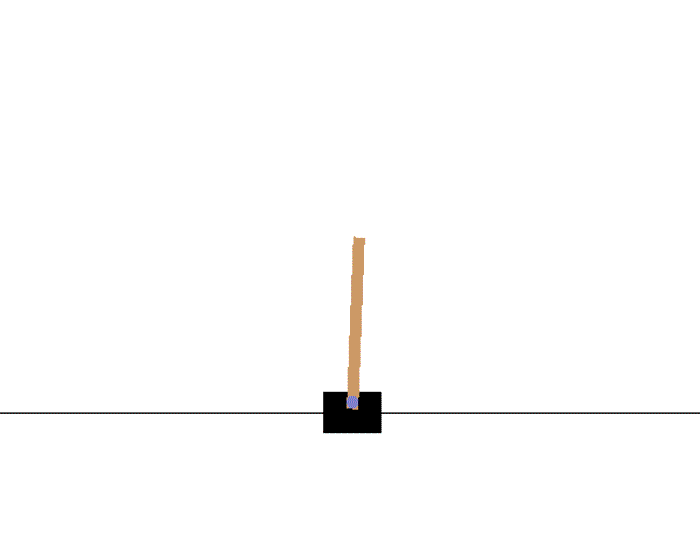

In [14]:
import gym
import ptan

from PIL import Image
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(200, 150))
display.start()

# ambiente
env = gym.make(DEFAULT_ENV_NAME)

# agente
net = PGN(env.observation_space.shape[0], env.action_space.n)
net.load_state_dict(torch.load(DEFAULT_ENV_NAME + "-PGN.dat"))
net.eval()
agent = ptan.agent.PolicyAgent(net, preprocessor=ptan.agent.float32_preprocessor,apply_softmax=True)

# conectando ambiente e agente
exp_source = ptan.experience.ExperienceSource(env, agent)

# start simulation
for i in range(1):
  done = False
  frames = []
  observation = env.reset()
  while not done:
    obs_v = torch.FloatTensor([observation])
    action = int(agent(obs_v)[0])
    observation, reward, done, info = env.step(action) 
    screen = Image.fromarray(env.render(mode='rgb_array'))
    screen = screen.resize(size=(700, 550))
    frames.append(screen) 

env.close()

frames[0].save('episode.gif', format='GIF',
               append_images=frames[1:], save_all=True, loop = 100, duration =0.0001)

show_gif('episode.gif')

Agente com politica aleatória


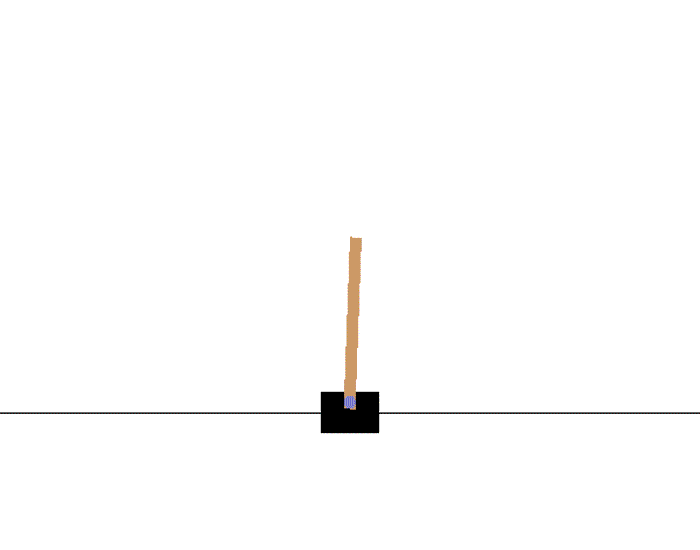

In [10]:
from PIL import Image
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(200, 150))
display.start()

env = gym.make(DEFAULT_ENV_NAME)
observation = env.reset()
for i in range(1):
  done = False
  frames = []
  while not done:
    #env.render()
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)   
    screen = Image.fromarray(env.render(mode='rgb_array'))
    screen = screen.resize(size=(700, 550))
    frames.append(screen)   
    #if done:
    #    observation = env.reset() 

env.close()
frames[0].save('episode.gif', format='GIF',
               append_images=frames[1:], save_all=True, loop = 100, duration =0.0001)

show_gif('episode.gif')